This notebook compares the performance of basic __map__ and __filter__ operators between Rocket.jl, Signals.jl and Reactive.jl. We also compare __map__ operation with Rocket.jl and Observables.jl in synchronous mode.

In [1]:
import Pkg;

In [2]:
Pkg.activate(; temp = true)

  Activating new project at `/var/folders/kf/1t2_wf7n49sgxmzzmmgsb1j40000gn/T/jl_KAd85R`


In [3]:
Pkg.add([ "Rocket", "BenchmarkTools", "Statistics", "Reactive", "Signals", "Observables", "StatsPlots", "ColorSchemes", "Colors", "PyPlot" ])

   Resolving package versions...


    Updating `/private/var/folders/kf/1t2_wf7n49sgxmzzmmgsb1j40000gn/T/jl_KAd85R/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.3.2
  [35d6a980] + ColorSchemes v3.24.0
  [5ae59095] + Colors v0.12.10
  [510215fc] + Observables v0.5.4
  [d330b81b] + PyPlot v2.11.2
  [a223df75] + Reactive v0.8.3
  [df971d30] + Rocket v1.7.2
  [6303bc30] + Signals v1.2.0
  [f3b207a7] + StatsPlots v0.15.6
  [10745b16] + Statistics v1.9.0
    Updating `/private/var/folders/kf/1t2_wf7n49sgxmzzmmgsb1j40000gn/T/jl_KAd85R/Manifest.toml`
  [621f4979] + AbstractFFTs v1.5.0
  [79e6a3ab] + Adapt v3.6.2
  [7d9fca2a] + Arpack v0.5.4
  [13072b0f] + AxisAlgorithms v1.0.1
  [6e4b80f9] + BenchmarkTools v1.3.2
  [d1d4a3ce] + BitFlags v0.1.7
  [49dc2e85] + Calculus v0.5.1
  [d360d2e6] + ChainRulesCore v1.16.0
  [aaaa29a8] + Clustering v0.15.4
  [944b1d66] + CodecZlib v0.7.2
  [35d6a980] + ColorSchemes v3.24.0
  [3da002f7] + ColorTypes v0.11.4
  [c3611d14] + ColorVectorSpace v0.10.0
  [5ae59095] + Colors v0.12.10
  [34da2185


  [c22f9ab0] + Xorg_xcb_util_wm_jll v0.4.1+1
  [35661453] + Xorg_xkbcomp_jll v1.4.6+0
  [33bec58e] + Xorg_xkeyboard_config_jll v2.39.0+0
  [c5fb5394] + Xorg_xtrans_jll v1.5.0+0
  [3161d3a3] + Zstd_jll v1.5.5+0
  [35ca27e7] + eudev_jll v3.2.9+0
⌅ [214eeab7] + fzf_jll v0.29.0+0
  [1a1c6b14] + gperf_jll v3.1.1+0
  [a4ae2306] + libaom_jll v3.4.0+0
  [0ac62f75] + libass_jll v0.15.1+0
  [2db6ffa8] + libevdev_jll v1.11.0+0
  [f638f0a6] + libfdk_aac_jll v2.0.2+0
  [36db933b] + libinput_jll v1.18.0+0
  [b53b4c65] + libpng_jll v1.6.38+0
  [f27f6e37] + libvorbis_jll v1.3.7+1
  [009596ad] + mtdev_jll v1.1.6+0
  [1270edf5] + x264_jll v2021.5.5+0
  [dfaa095f] + x265_jll v3.5.0+0
  [d8fb68d0] + xkbcommon_jll v1.4.1+1
  [0dad84c5] + ArgTools v1.1.1
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [8ba89e20] + Distributed
  [f43a241f] + Downloads v1.6.0
  [7b1f6079] + FileWatching
  [b77e0a4c] + InteractiveUtils
  [4af54fe1] + LazyArtifacts
  [b27032c2] + LibCURL v0.6.3
  [76f8545

In [4]:
ENV["REACTIVE_CHANNEL_SIZE"] = typemax(Int)

using Rocket
using BenchmarkTools
using Statistics

import Reactive
import Signals
import Observables

In [5]:
const N = 30000;

In [6]:
# General function for Rocket.jl takes any operator as an argument and sync/async modes
function rocket_jl(operator; scheduler = AsyncScheduler())  
    source = Subject(Int, scheduler = scheduler)
    mapped = source |> operator
    
    # It is also possible to use a KeepActor here, but lets use a lambda here to match with the others
    values = Vector{Int}() 
    
    # sync(...) wraps an actor and allows to 'wait' for completion
    actor  = sync(lambda(on_next = (d) -> push!(values, d))) 
    
    subscribe!(mapped, actor)
    
    yield() # Force to execute of subscribtion task in case of AsyncScheduler
    
    for i in 0:N
        next!(source, i)
    end
    complete!(source)
    
    wait(actor)
    
    return values
end;

#### Map operator

In [7]:
function reactive_jl_map()
    x = Reactive.Signal(0)
    mapped = Reactive.preserve(Reactive.map(a -> a ^ 2, x))
    values = Vector{Int}()
    Reactive.foreach(s -> push!(values, s), mapped)
    # stored = Reactive.preserve(Reactive.map())
    for i in 1:N
        push!(x, i)
    end
    yield()
    # `Reactive.jl` is a bit unstable here
    retry = 0
    while length(values) <= N
        yield()
        retry += 1
        if retry > 5 
            error("Did not record all values") 
        end
    end
    return values
end

function signals_jl_map(; async_mode = true)
    Signals.async_mode(async_mode)
    
    x = Signals.Signal(0, strict_push = true)
    m = Signals.Signal(x -> x ^ 2, x)

    values = Vector{Int}()
    Signals.Signal(x -> push!(values, x), m, strict_push = true)
    
    for i in 1:N
        x(i)
    end

    Signals.run_till_now()
    yield()
    
    return values
end

function observables_jl_map()
    x = Observables.Observable(0)
    
    m = map(x -> x ^ 2, x)
    
    values = Vector{Int}()
    Observables.on(m) do v
        push!(values, v)
    end
    
    for i in 0:N
        x[] = i
    end
    
    return values
end

squared_operator = map(Int, d -> d ^ 2);

In [8]:
@show reactive_jl_map() == observables_jl_map()
@show reactive_jl_map() == rocket_jl(squared_operator, scheduler = AsyncScheduler())
@show reactive_jl_map() == rocket_jl(squared_operator, scheduler = AsapScheduler())
@show reactive_jl_map() == signals_jl_map(async_mode = true)
@show reactive_jl_map() == signals_jl_map(async_mode = false)

reactive_jl_map() == observables_jl_map() = true


reactive_jl_map() == rocket_jl(squared_operator, scheduler = AsyncScheduler()) = true
reactive_jl_map() == rocket_jl(squared_operator, scheduler = AsapScheduler()) = true


reactive_jl_map() == signals_jl_map(async_mode = true) = true


reactive_jl_map() == signals_jl_map(async_mode = false) = true


true

In [9]:
bmap1 = @benchmark reactive_jl_map();
bmap2 = @benchmark signals_jl_map(async_mode = true);
bmap3 = @benchmark signals_jl_map(async_mode = false);
bmap4 = @benchmark rocket_jl($squared_operator, scheduler = AsyncScheduler());
bmap5 = @benchmark rocket_jl($squared_operator, scheduler = AsapScheduler());
bmap6 = @benchmark observables_jl_map();

In [10]:
presult(name, benchmark) = println(name, BenchmarkTools.prettytime(time(benchmark)), " | ", BenchmarkTools.prettymemory(memory(benchmark)))

presult (generic function with 1 method)

In [11]:
presult("Reactive.jl    |         map | ", bmap1)
presult("Signals.jl     | async + map | ", bmap2)
presult("Signals.jl     | sync  + map | ", bmap3)
presult("Rocket.jl      | async + map | ", bmap4)
presult("Rocket.jl      | sync  + map | ", bmap5)
presult("Observables.jl |         map | ", bmap6)

Reactive.jl    |         map | 18.921 ms | 9.02 MiB
Signals.jl     | async + map | 6.786 ms | 13.82 MiB
Signals.jl     | sync  + map | 4.347 ms | 7.65 MiB
Rocket.jl      | async + map | 2.985 ms | 2.05 MiB
Rocket.jl      | sync  + map | 951.542 μs | 1.24 MiB
Observables.jl |         map | 14.790 ms | 5.34 MiB


#### Filter operator

In [12]:
function reactive_jl_filter()
    x = Reactive.Signal(0)
    mapped = Reactive.filter(a -> a % 2 == 0, x)
    values = Vector{Int}()
    Reactive.foreach(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    # `Reactive.jl` is a bit unstable here
    retry = 0
    while length(values) <= (N / 2)
        yield()
        retry += 1
        if retry > 5 
            error("Did not record all values") 
        end
    end
    return values
end

function signals_jl_filter(; async_mode = true)
    Signals.async_mode(async_mode)
    
    x = Signals.Signal(0, strict_push = true)
    m = Signals.filter(x -> x % 2 == 0, 0, x)

    values = Vector{Int}()
    Signals.Signal(x -> push!(values, x), m, strict_push = true)
    
    for i in 1:N
        x(i)
    end
    
    Signals.run_till_now()
    yield()
    
    return values
end

even_operator = filter(x -> x % 2 == 0);

In [13]:
@show reactive_jl_filter() == rocket_jl(even_operator, scheduler = AsyncScheduler())
@show reactive_jl_filter() == rocket_jl(even_operator, scheduler = AsapScheduler())
@show reactive_jl_filter() == signals_jl_filter(async_mode = true)
@show reactive_jl_filter() == signals_jl_filter(async_mode = false)

reactive_jl_filter() == rocket_jl(even_operator, scheduler = AsyncScheduler()) = true


reactive_jl_filter() == rocket_jl(even_operator, scheduler = AsapScheduler()) = true
reactive_jl_filter() == signals_jl_filter(async_mode = true) = true


reactive_jl_filter() == signals_jl_filter(async_mode = false) = true


true

In [14]:
bfilter1 = @benchmark reactive_jl_filter();
bfilter2 = @benchmark signals_jl_filter(async_mode = true);
bfilter3 = @benchmark signals_jl_filter(async_mode = false);
bfilter4 = @benchmark rocket_jl($even_operator, scheduler = AsyncScheduler());
bfilter5 = @benchmark rocket_jl($even_operator, scheduler = AsapScheduler());

In [15]:
presult("Reactive.jl |         filter | ", bfilter1)
presult("Signals.jl  | async + filter | ", bfilter2)
presult("Signals.jl  | sync  + filter | ", bfilter3)
presult("Rocket.jl   | async + filter | ", bfilter4)
presult("Rocket.jl   | sync  + filter | ", bfilter5)

Reactive.jl |         filter | 18.530 ms | 8.31 MiB
Signals.jl  | async + filter | 7.729 ms | 12.89 MiB
Signals.jl  | sync  + filter | 5.160 ms | 6.71 MiB
Rocket.jl   | async + filter | 2.926 ms | 1.57 MiB
Rocket.jl   | sync  + filter | 777.250 μs | 787.91 KiB


In [16]:
using StatsPlots ; 
using ColorSchemes, Colors ;

pyplot(grid=:false) ; c = palette(:rainbow)

c1 = get(ColorSchemes.rainbow, 0.5) ; 
c2 = get(ColorSchemes.rainbow, 0.2) ; 
c3 = get(ColorSchemes.rainbow, 0.3) ; 
c4 = get(ColorSchemes.rainbow, 0.8) ; 
c5 = get(ColorSchemes.rainbow, 0.9) ; 
c6 = get(ColorSchemes.rainbow, 0.4) ; 

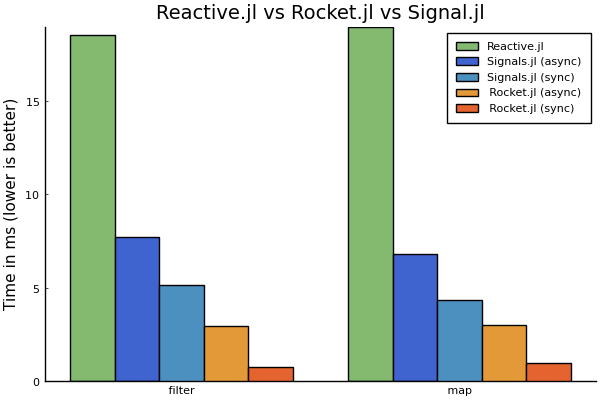

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [17]:
mn = [
    time(bmap1), time(bfilter1),
    time(bmap2), time(bfilter2),
    time(bmap3), time(bfilter3),
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
] ./ 1e6
sx = repeat(["Reactive.jl", "Signals.jl (async)", "Signals.jl (sync)", " Rocket.jl (async)", " Rocket.jl (sync)"], inner = 2)
nam = repeat([ " map ", " filter " ], outer = 5)

groupedbar(nam, mn, group = sx, ylabel = "Time in ms (lower is better)", title = "Reactive.jl vs Rocket.jl vs Signal.jl", color=[c1 c2 c3 c4 c5])

In [18]:
sx = repeat(["Reactive.jl", "Rocket.jl (async)", "Rocket.jl (sync)"], inner = 2)
nam = repeat([ " map ", " filter " ], outer = 3)

mn = [
    bmap1, bfilter1,
    bmap4, bfilter4,
    bmap5, bfilter5,
]

p1 = groupedbar(nam, time.(mn)./1e6, group = sx, ylabel = "Time in ms (lower is better)", title = "Reactive.jl vs Rocket.jl (time)", color=[c1 c4 c5], legend=:topright)
p2 = groupedbar(nam, memory.(mn)./2^20, group = sx, ylabel = "Memory in MiB (lower is better)", title = "Reactive.jl vs Rocket.jl (memory)", color=[c1 c4 c5], legend=:topright)

p = plot(p1, p2, size = (900, 400), layout = grid(1, 2))

savefig("pics/reactive-rocket.svg")

"/Users/bvdmitri/.julia/dev/Rocket.jl/demo/pics/reactive-rocket.svg"

In [19]:
mn = [
    bmap4, bmap5, bfilter4, bfilter5,
    bmap2, bmap3, bfilter2, bfilter3
]

sx = repeat([" Rocket.jl", "Signals.jl"], inner = 4)
nam = repeat([ " map (async) ", " map (sync) ", " filter (async) ", " filter(sync) " ], outer = 2)

p1 = groupedbar(nam, time.(mn)./1e6, group = sx, ylabel = "Time in ms (lower is better)", title = "Signals.jl vs Rocket.jl (time)", color=[c2 c4])
p2 = groupedbar(nam, memory.(mn)./2^20, group = sx, ylabel = "Memory in MiB (lower is better)", title = "Signals.jl vs Rocket.jl (memory)", color=[c2 c4])

p = plot(p1, p2, size = (900, 400), layout = grid(1, 2))

savefig("pics/signals-rocket.svg")

"/Users/bvdmitri/.julia/dev/Rocket.jl/demo/pics/signals-rocket.svg"

In [20]:
sx = repeat(["Observables.jl", "Rocket.jl (async)", "Rocket.jl (sync)"], inner = 1)
nam = repeat([ " map " ], outer = 3)

mn = [
    bmap6
    bmap4
    bmap5
]

p1 = groupedbar(nam, time.(mn)./1e6, bar_edges = false, group = sx, ylabel = "Time in ms (lower is better)", title = "Observables.jl vs Rocket.jl (time)", color=[c6 c4 c5], legend=:topright)
p2 = groupedbar(nam, memory.(mn)./2^20, bar_edges = false, group = sx, ylabel = "Memory in MiB (lower is better)", title = "Observables.jl vs Rocket.jl (memory)", color=[c6 c4 c5], legend=:topright)

p = plot(p1, p2, size = (900, 400), layout = grid(1, 2))

savefig("pics/observables-rocket.svg")

"/Users/bvdmitri/.julia/dev/Rocket.jl/demo/pics/observables-rocket.svg"

In [21]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 10 × Apple M2 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, apple-m1)
  Threads: 1 on 6 virtual cores
Environment:
  JULIA_NUM_THREADS = 


In [22]:
import Pkg; Pkg.status()

Status `/private/var/folders/kf/1t2_wf7n49sgxmzzmmgsb1j40000gn/T/jl_KAd85R/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [35d6a980] ColorSchemes v3.24.0
  [5ae59095] Colors v0.12.10
  [510215fc] Observables v0.5.4
  [d330b81b] PyPlot v2.11.2
  [a223df75] Reactive v0.8.3
  [df971d30] Rocket v1.7.2
  [6303bc30] Signals v1.2.0
  [f3b207a7] StatsPlots v0.15.6
  [10745b16] Statistics v1.9.0
